## **Model Showcase**

### **1. Import the necessary libraries**


In [14]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import cv2
import os
from utils.contour_cropping import crop_black_borders
from utils.contour_cropping import make_square
from utils.resize_image import resize_and_convert_to_grayscale
from utils.get_categories import get_categories

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


### **2. Run the following codes with CUDA GPU enabled**


In [15]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


### **3. Data Pre-Processing**


Categories: ['glioma', 'meningioma', 'notumor', 'pituitary']


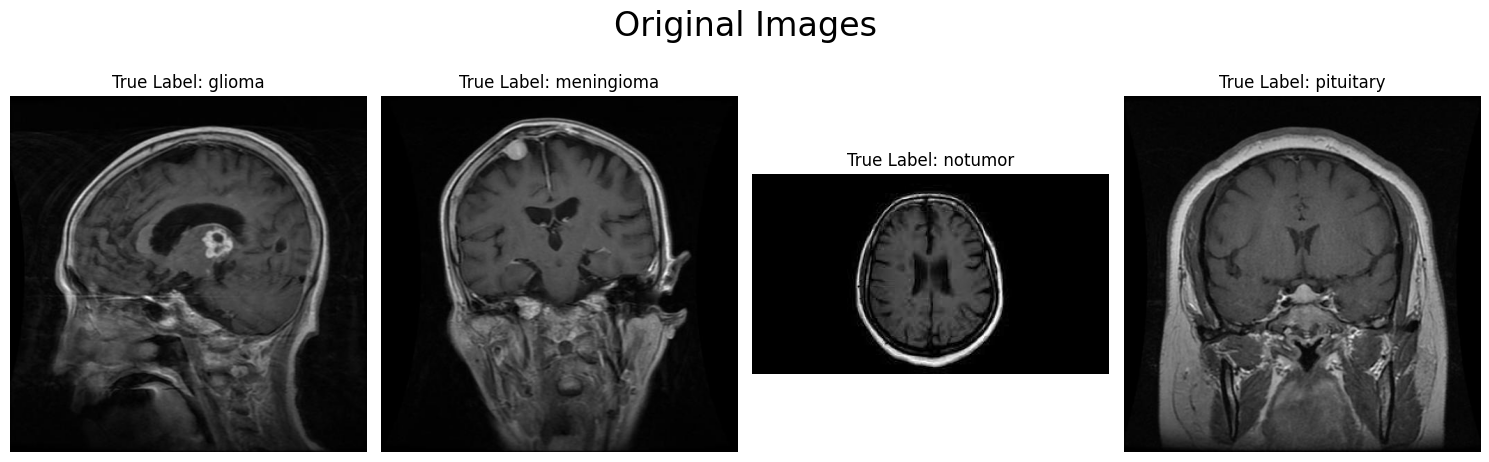

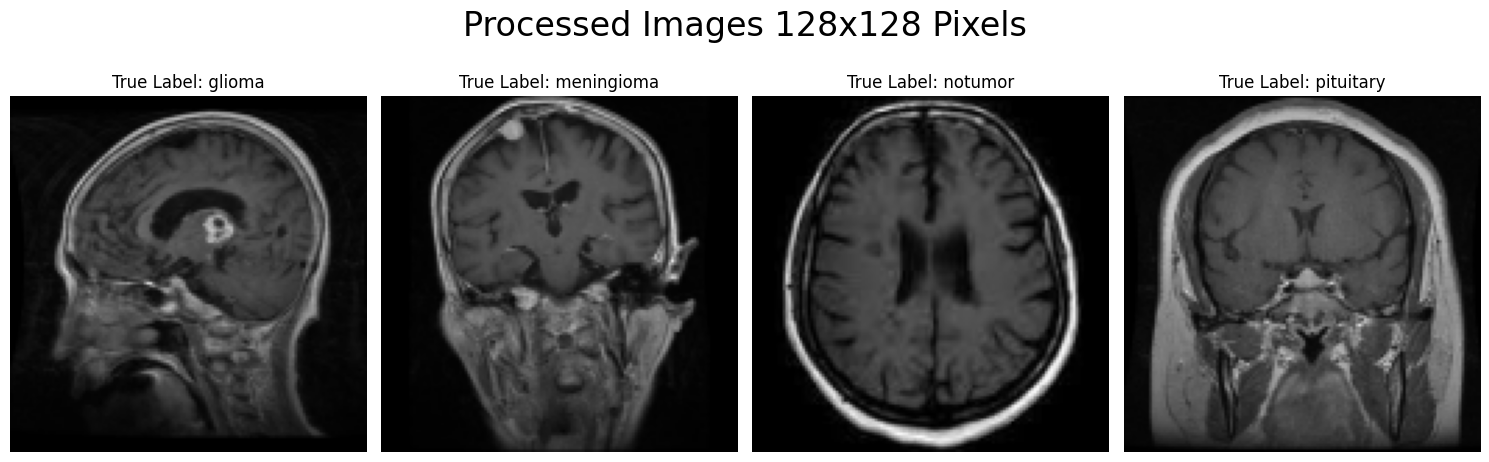

In [16]:
image_index = 33
resize_value= 128

def orignal_images(data_dir, categories):
    fig, axes = plt.subplots(1, len(categories), figsize=(15, 10))
    for ax, category in zip(axes, categories):
        category_path = os.path.join(data_dir, category)
        sample_image_path = os.path.join(category_path, os.listdir(category_path)[image_index])
        sample_image_gray = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
        sample_image = cv2.cvtColor(sample_image_gray, cv2.COLOR_BGR2RGB)
        ax.imshow(sample_image)
        ax.set_title("True Label: "+category)
        ax.axis("off")
    plt.suptitle("Original Images", fontsize=24)
    plt.tight_layout(rect=[0, 0.03, 1, 1.45])
    plt.show()

def process_images(data_dir, categories, threshold_value=10):
    images_to_predict = []
    fig, axes = plt.subplots(1, len(categories), figsize=(15, 10))
    for ax, category in zip(axes, categories):
        category_path = os.path.join(data_dir, category)
        sample_image_path = os.path.join(category_path, os.listdir(category_path)[image_index])
        sample_image_gray = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
        cropped_image = crop_black_borders(sample_image_gray, threshold_value)
        square_image = make_square(cropped_image)
        resized_image = resize_and_convert_to_grayscale(
            square_image, resize_value
        )
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        ax.imshow(resized_image)
        ax.set_title("True Label: "+category)
        ax.axis("off")
        images_to_predict.append(resized_image)
    plt.suptitle(f"Processed Images {resize_value}x{resize_value} Pixels", fontsize=24)
    plt.tight_layout(rect=[0, 0.03, 1, 1.45])
    plt.show()
    return images_to_predict


data_dir = "./DATASETS/dataset_4"
categories = get_categories(data_dir)
orignal_images(data_dir, categories)
images_to_predict = process_images(data_dir, categories)


### **4. Prediction**


1/1 [==============================] - 0s 20ms/step


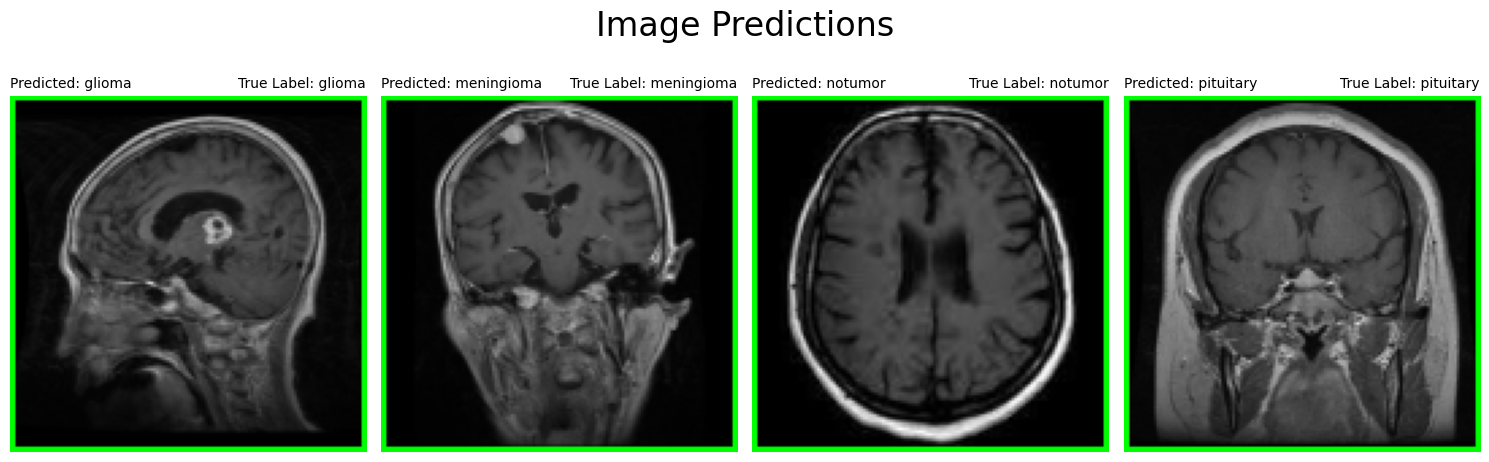

In [17]:
# Load the saved model
mode_name = "./MobileNet/mobilenet_128_model_kfold.h5"
model = load_model(mode_name)

# Recompile the model with the correct metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# ImageDataGenerator for normalization
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

fig, axes = plt.subplots(1, len(images_to_predict), figsize=(15, 10))

for ax, img, true_label in zip(axes, images_to_predict, categories):
    # Normalize the image
    img_normalized = test_datagen.flow(np.expand_dims(img, axis=0), batch_size=1).next()

    # Predict the class
    prediction = model.predict(img_normalized)
    predicted_label = np.argmax(prediction, axis=1)[0]

    # Determine border color
    border_color = 'green' if predicted_label == categories.index(true_label) else 'red'

    # Draw border around the image
    img_with_border = cv2.copyMakeBorder(
        img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[0, 255, 0] if border_color == 'green' else [255, 0, 0]
    )

    # Display image with the border
    ax.imshow(img_with_border)
    ax.set_title(f"True Label: {true_label}", loc='right', fontsize=10)
    ax.set_title(f"Predicted: {categories[predicted_label]}", loc='left', fontsize=10)
    ax.axis("off")

plt.suptitle("Image Predictions", fontsize=24)
plt.tight_layout(rect=[0, 0.03, 1, 1.45])
plt.show()